# Momentum-Based Trading Strategy Project

**Author:** Ani Pottammal

This Jupyter notebook documents my work on the Momentum-Based Trading Strategy Project for the PGI's 2024 Summer Assignment. The goal is to develop a momentum trading strategy for DJIA stocks, showcasing a comprehensive alpha development approach from data collection to signal generation to portfolio construction to strategy evaluation.

In [700]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

# Suppress specific warnings about future deprecations
warnings.filterwarnings("ignore", category=FutureWarning, message="'M' is deprecated and will be removed in a future version")

# List of DJIA stock symbols
djia_stocks = [
    'AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD',
    'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM'
]

# Define the start and end date for the data fetch
start_date = "2000-01-01"
end_date = "2024-01-01"

# Function to fetch stock data from Yahoo Finance
def fetch_data(stocks, start, end):
    all_data = []
    for stock in stocks:
        df = yf.download(stock, start=start, end=end)
        ticker = yf.Ticker(stock)
        market_cap = ticker.info.get('marketCap', np.nan)
        df['Symbol'] = stock
        df['Market_cap'] = float(market_cap)
        all_data.append(df)
    return pd.concat(all_data)

# Fetching data for all DJIA stocks
final_df = fetch_data(djia_stocks, start_date, end_date)

# Resetting index and handling missing data by forward and backward filling
final_df = final_df.reset_index().set_index('Date')
final_df.ffill(inplace=True)
final_df.bfill(inplace=True)
final_df['daily_return'] = final_df.groupby('Symbol', observed=True)['Adj Close'].pct_change()
final_df.dropna(subset=['daily_return'], inplace=True)

# Function to calculate momentum over specified periods
def calculate_momentum(df, periods):
    momentum = df['Adj Close'].pct_change(periods=periods)
    count_non_na = df['Adj Close'].rolling(window=252).count()
    momentum[count_non_na < 189] = np.nan # at least 9 months of returns
    return momentum

# Define lookback periods for momentum calculations
lookback_periods = {
    '3m': 63,
    '6m': 126,
    '11m': 231,
    '12m': 252,
}

# Calculate momentum for each period and add to the dataframe
for label, period in lookback_periods.items():
    final_df[f'momentum_{label}'] = final_df.groupby('Symbol')['Adj Close'].transform(lambda x: x.pct_change(periods=period))

# Calculate and display summary statistics for each momentum period
summary_stats = []

for label in lookback_periods.keys():
    momentum_data = final_df[f'momentum_{label}']
    stats = {
        'Mean': momentum_data.mean(),
        'SD': momentum_data.std(),
        'Skew': momentum_data.skew(),
        'Kurt': momentum_data.kurtosis(),
        'Min': momentum_data.min(),
        '5%': momentum_data.quantile(0.05),
        '25%': momentum_data.quantile(0.25),
        'Median': momentum_data.median(),
        '75%': momentum_data.quantile(0.75),
        '95%': momentum_data.quantile(0.95),
        'Max': momentum_data.max(),
        'n': momentum_data.count()
    }
    summary_stats.append(pd.Series(stats, name=f'Momentum_{label}'))

summary_df = pd.DataFrame(summary_stats)

print(summary_df)  # Display the summary statistics dataframe

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

                  Mean        SD      Skew      Kurt       Min        5%  \
Momentum_3m   0.028630  0.128134  0.172407  3.611423 -0.770668 -0.172632   
Momentum_6m   0.058002  0.184248  0.613319  5.052893 -0.763301 -0.225934   
Momentum_11m  0.108989  0.260618  0.925544  4.870917 -0.803882 -0.278703   
Momentum_12m  0.119616  0.274421  1.024006  5.425239 -0.816115 -0.284320   

                   25%    Median       75%       95%       Max         n  
Momentum_3m  -0.044075  0.028441  0.100823  0.226223  1.477048  166322.0  
Momentum_6m  -0.046230  0.055224  0.158490  0.342859  2.230311  164495.0  
Momentum_11m -0.045935  0.095628  0.246061  0.527006  2.825392  161450.0  
Momentum_12m -0.044248  0.103507  0.263395  0.557291  3.012020  160841.0  


                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     22.96
Date:                Sat, 13 Jul 2024   Prob (F-statistic):           7.49e-19
Time:                        01:44:47   Log-Likelihood:                 13780.
No. Observations:                5784   AIC:                        -2.755e+04
Df Residuals:                    5779   BIC:                        -2.752e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.504   

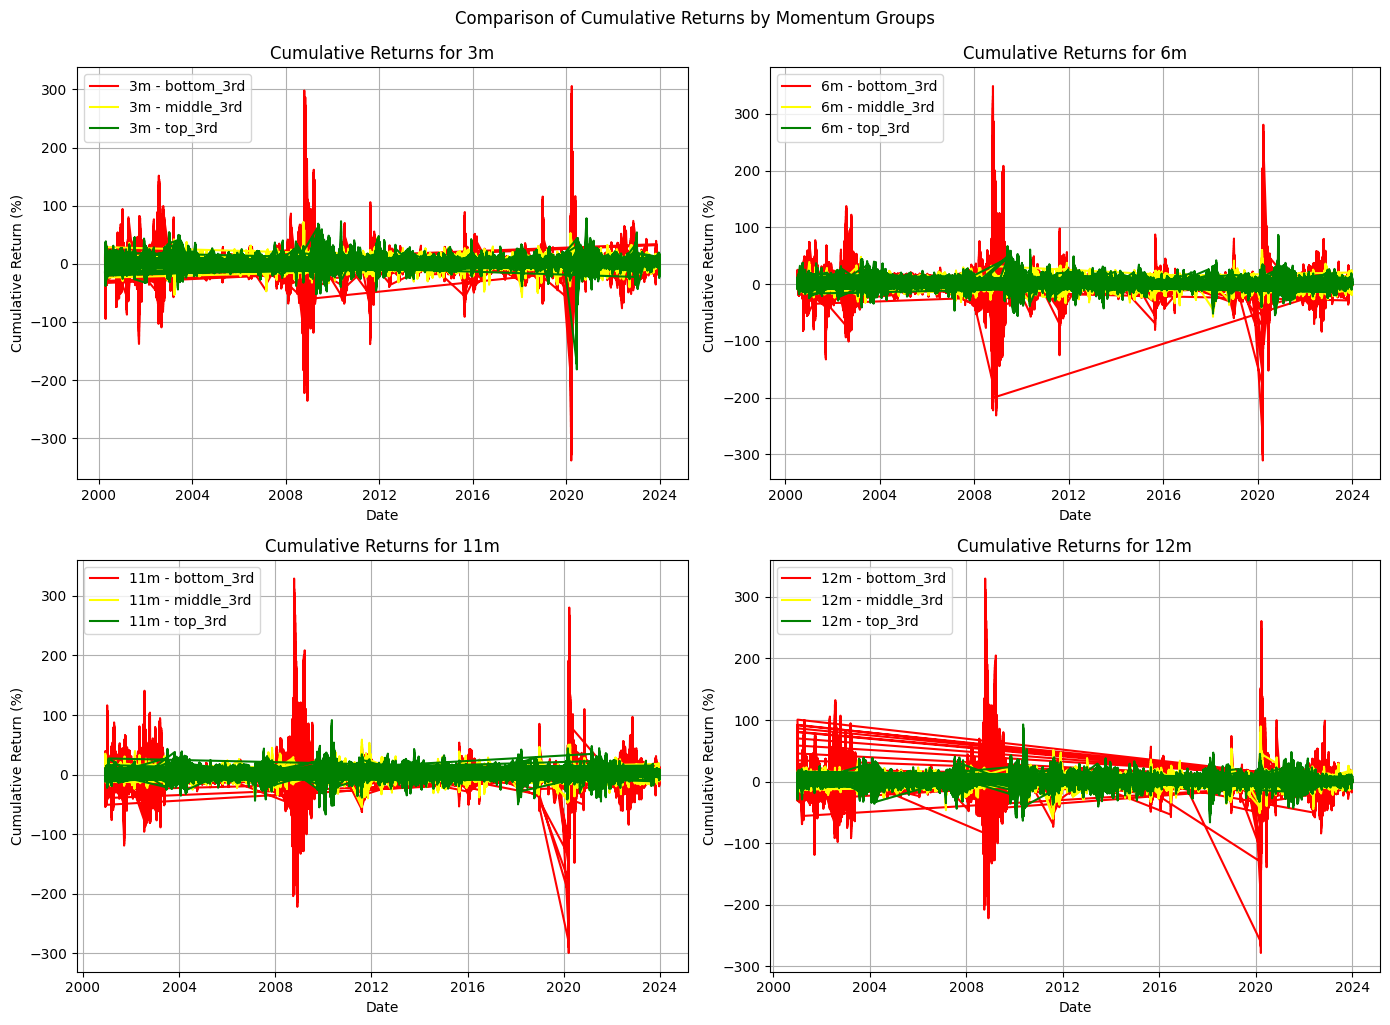

In [701]:
# Prepare independent (X) and dependent (y) variables for regression
X = final_df[[f'momentum_{label}' for label in lookback_periods.keys()]]
X = sm.add_constant(X)  # Add a constant term to the independent variables
y = final_df['daily_return']
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN

# Ensure indices are unique and align X and y
if not X.index.is_unique:
    X = X[~X.index.duplicated(keep='first')]
if not y.index.is_unique:
    y = y[~y.index.duplicated(keep='first')]
X, y = X.align(y, join='inner', axis=0)
X.dropna(inplace=True)  # Drop rows with NaN values
y = y.loc[X.index] 

# Fit the OLS regression model and print the summary
model = sm.OLS(y, X).fit()
print(model.summary())

# Function to group data by momentum signal into thirds
def group_by_momentum(df, signal):
    df['momentum_group'] = pd.qcut(df[signal], q=3, labels=['bottom_3rd', 'middle_3rd', 'top_3rd'], duplicates='drop')
    return df

# Function to plot cumulative returns for each momentum group
def plot_grouped_data(df):

    colors = {
        'bottom_3rd': 'red',
        'middle_3rd': 'yellow',
        'top_3rd': 'green'
    }
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, period in enumerate(['3m', '6m', '11m', '12m']):
        ax = axes[i]
        label = f'momentum_{period}'
        df = group_by_momentum(final_df, label)
        for group, color in colors.items():
            if group == 'bottom_3rd':
                group_data = df[df[label].between(df[label].quantile(0.0), df[label].quantile(1.0/3))]
            elif group == 'middle_3rd':
                group_data = df[df[label].between(df[label].quantile(1.0/3), df[label].quantile(2.0/3))]
            else:
                group_data = df[df[label].between(df[label].quantile(2.0/3), df[label].quantile(1.0))]
            
            # Calculate cumulative returns
            cumulative_returns = group_data.groupby(group_data.index.get_level_values(0))['daily_return'].cumsum() * 100
            ax.plot(cumulative_returns, label=f"{period} - {group}", color=color)

        ax.set_title(f'Cumulative Returns for {period}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Return (%)')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Comparison of Cumulative Returns by Momentum Groups', y=1.02)
    plt.show()

# Plot the cumulative returns
plot_grouped_data(final_df)

[*********************100%%**********************]  1 of 1 completed


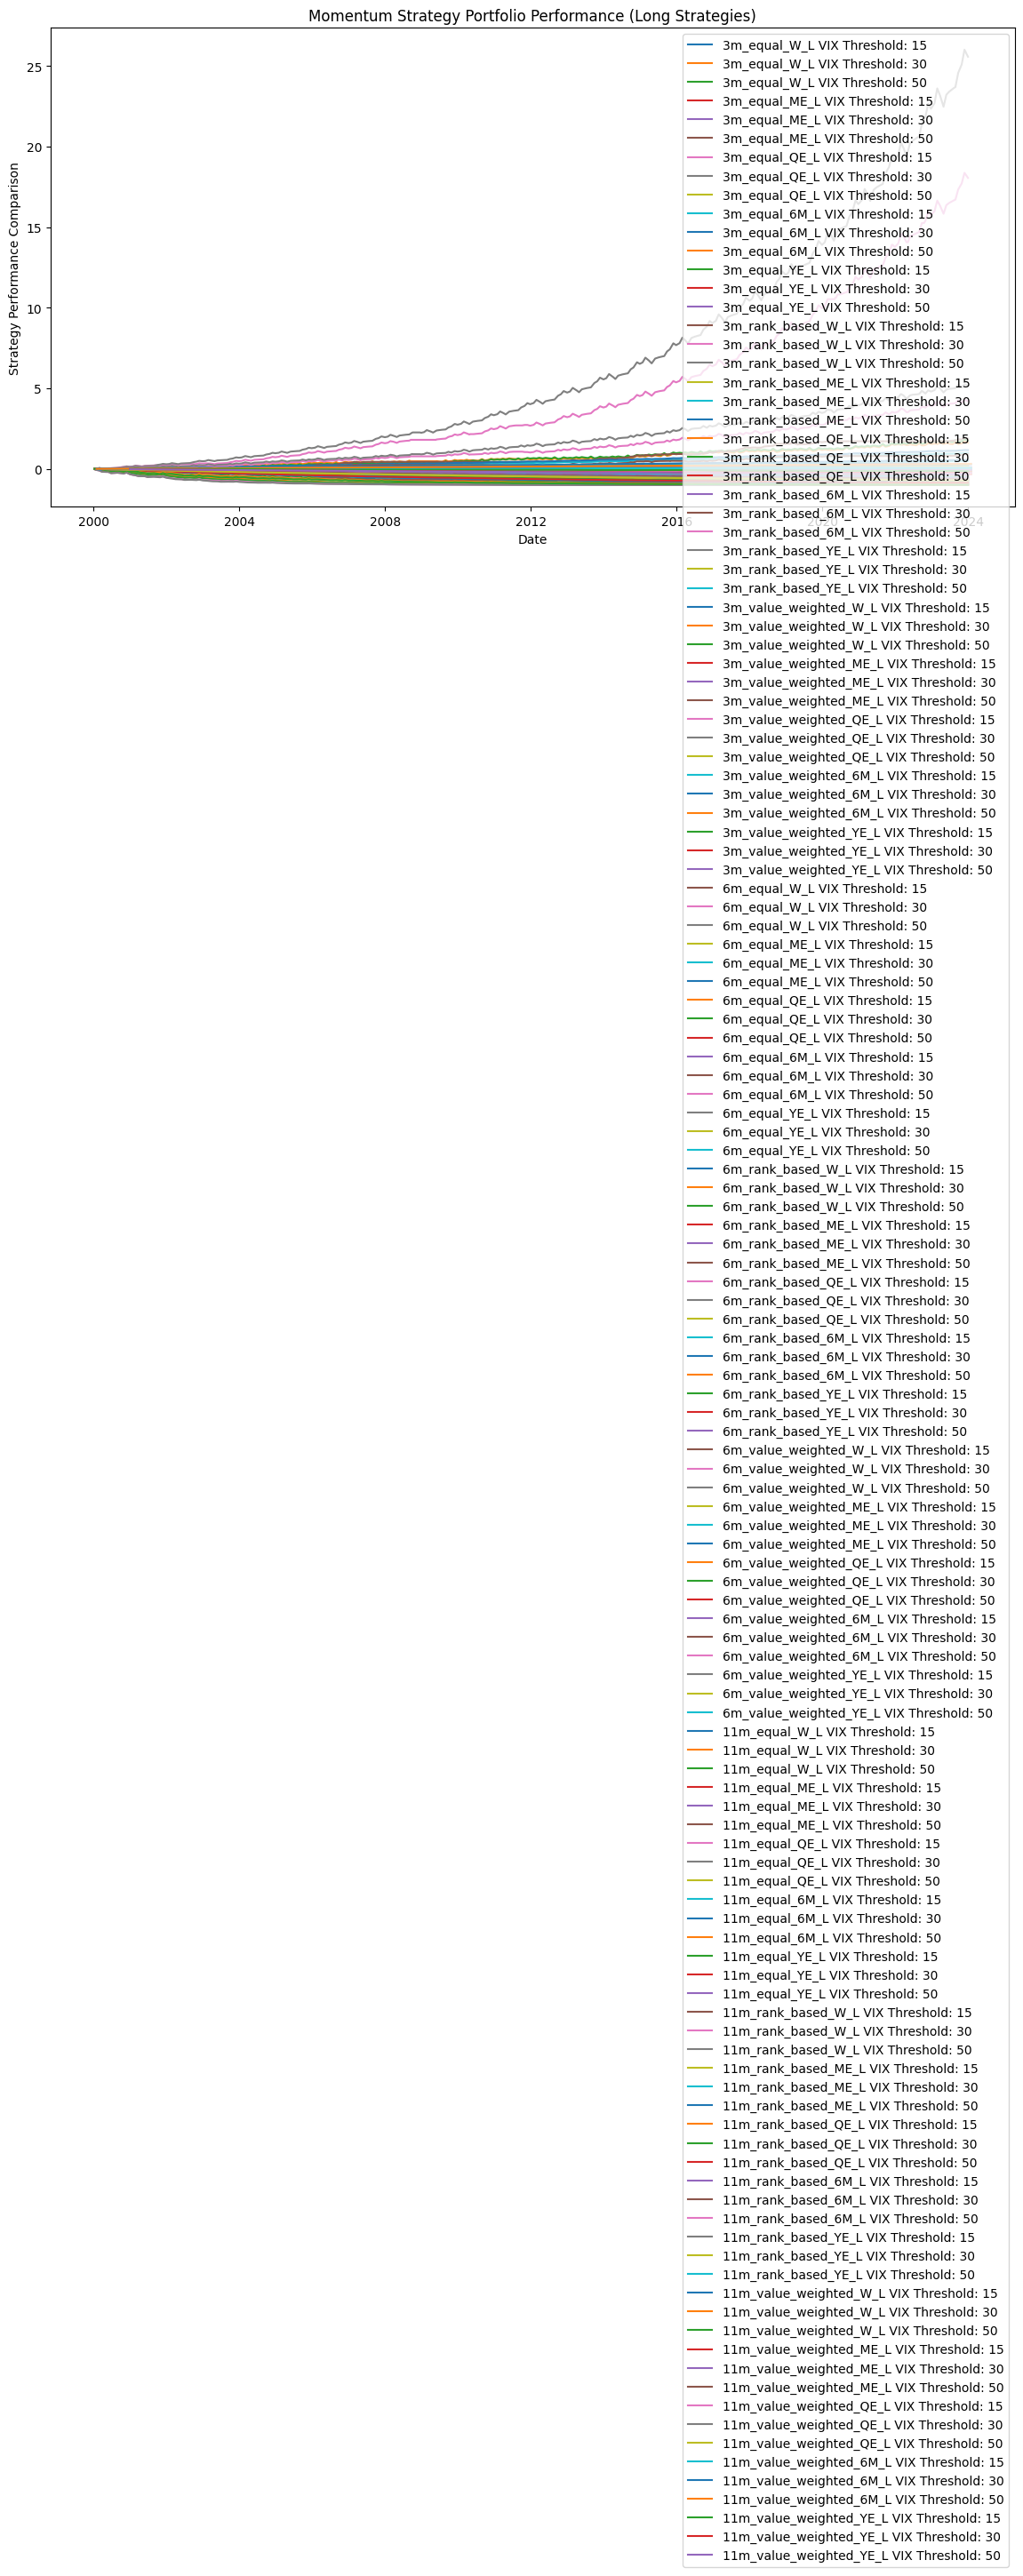

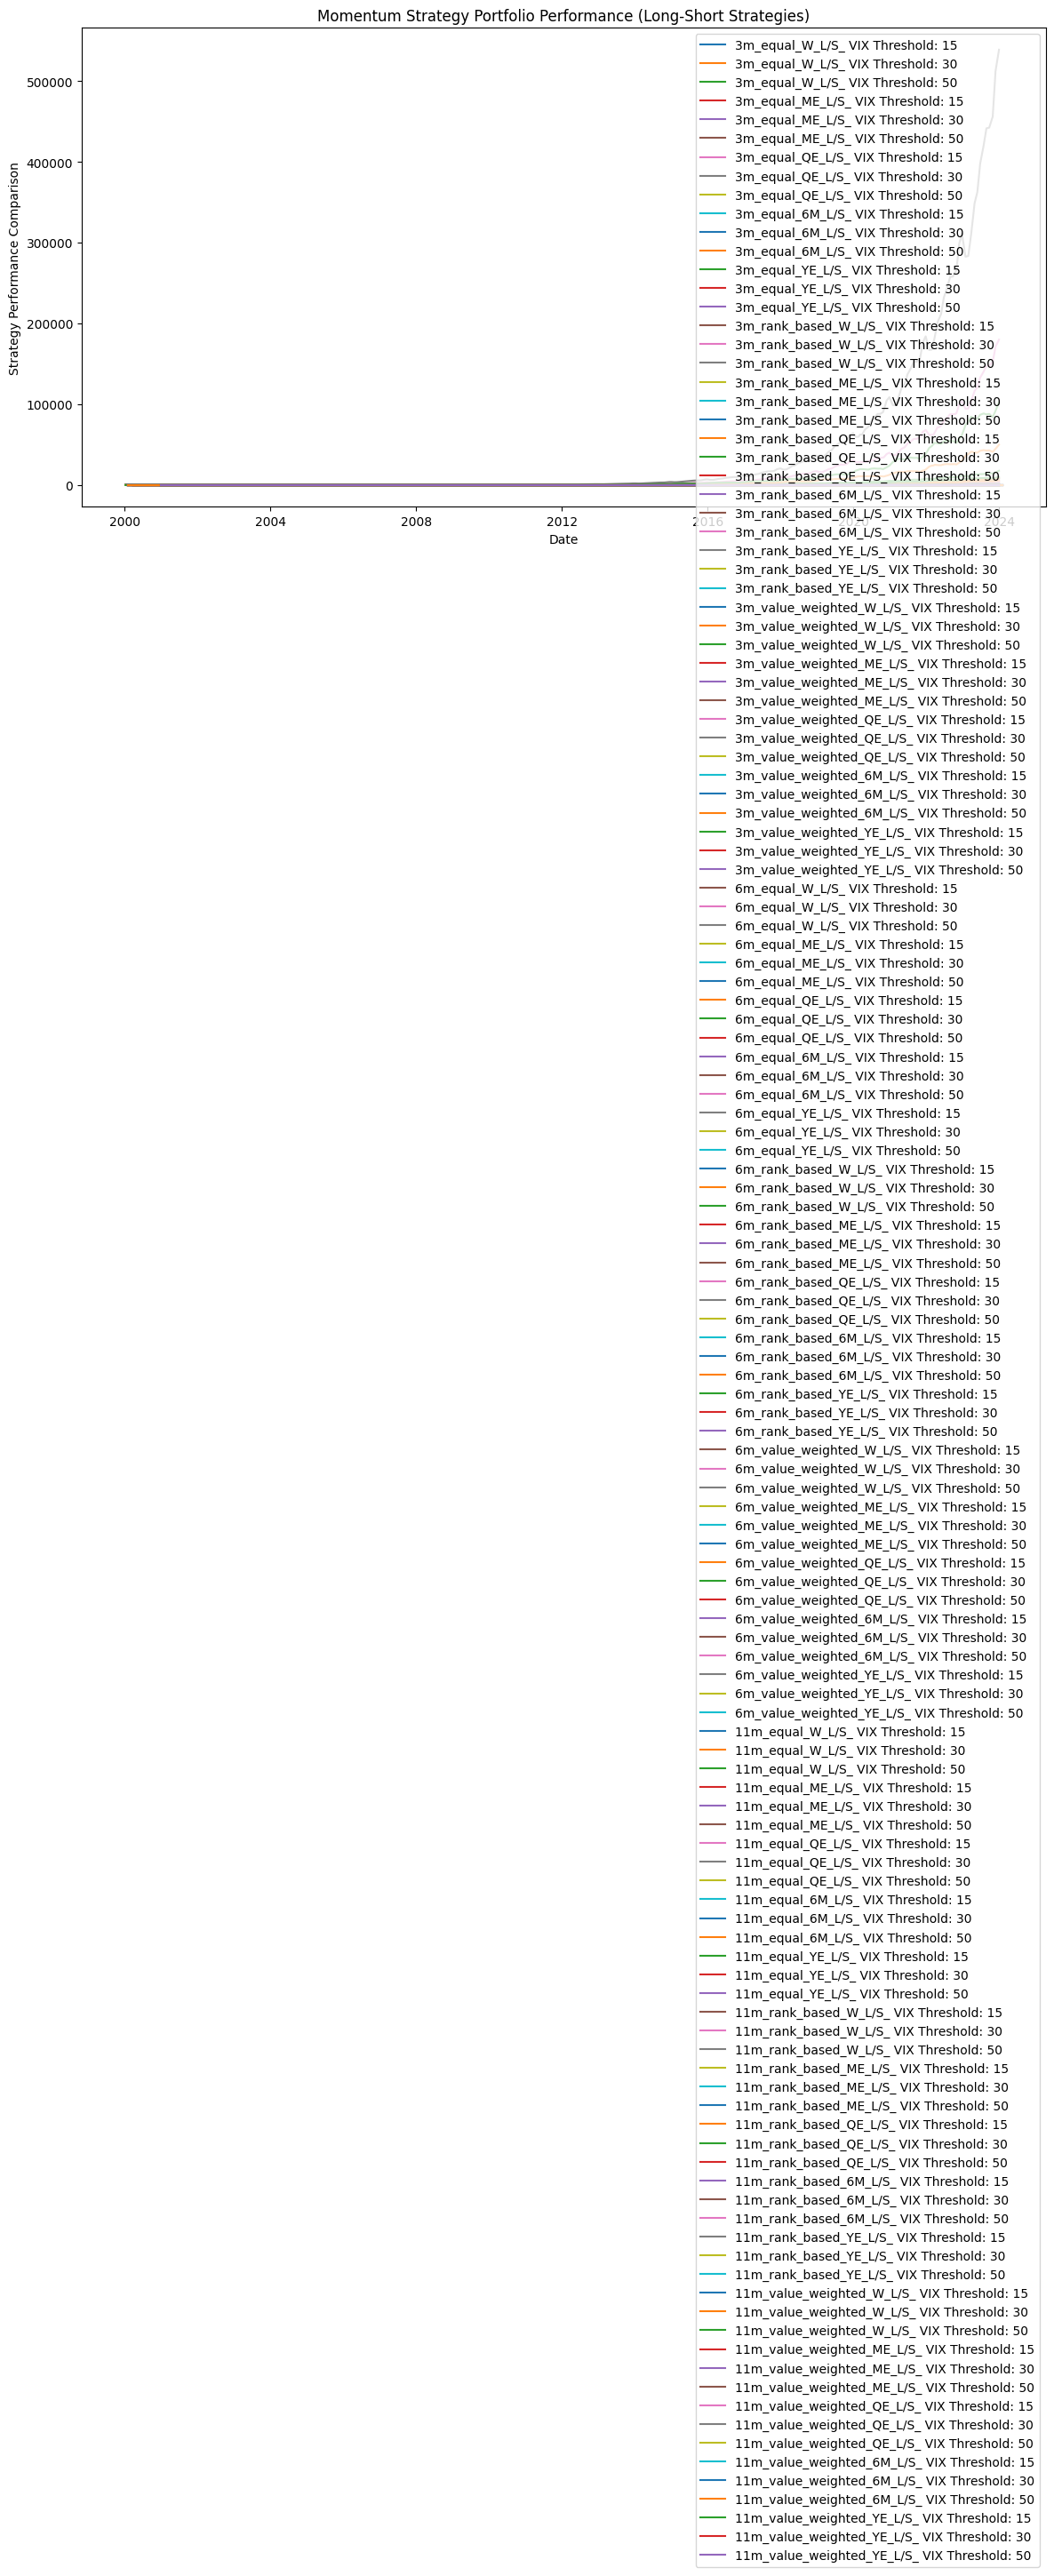

In [702]:
from itertools import product

# Class definition for momentum strategy
class MomentumStrategy:
    def __init__(self, df, signal, top_n=10, allocation_method='equal', rebalance_freq='ME', strategy_type='long'):
        self.df = df
        self.signal = signal
        self.top_n = top_n
        self.allocation_method = allocation_method
        self.rebalance_freq = rebalance_freq
        self.strategy_type = strategy_type
        self.portfolio_returns = []

    def calculate_monthly_returns(self):
        self.df['monthly_return'] = self.df.groupby('Symbol')['Adj Close'].pct_change().shift(-1)
        self.df['monthly_return'] = self.df['monthly_return'].fillna(0)

    def select_stocks(self, date, strategy_type='long'):
        month_df = self.df[self.df.index.month == date.month]
        if strategy_type == 'long':
            selected_stocks = month_df.nlargest(self.top_n, self.signal)
        elif strategy_type == 'short':
            selected_stocks = month_df.nsmallest(self.top_n, self.signal)
        selected_stocks['rank'] = np.arange(1, len(selected_stocks) + 1)
        average_market_caps = selected_stocks.groupby('Symbol')['Market_cap'].mean()
        selected_stocks['market_cap'] = selected_stocks['Symbol'].map(average_market_caps)
        return selected_stocks

    def allocate_weights(self, stocks):
        if self.allocation_method == 'equal':
            stocks['weight'] = 1.0 / self.top_n
        elif self.allocation_method == 'rank_based':
            stocks['weight'] = (self.top_n - stocks['rank']) / self.top_n
            stocks['weight'] /= stocks['weight'].sum()
        elif self.allocation_method == 'value_weighted':
            stocks['weight'] = stocks['market_cap'] / stocks['market_cap'].sum()
        return stocks

    def run_backtest(self, vix_data, vix_threshold):
        monthly_dates = self.df.resample(self.rebalance_freq).last().index
        vix_resampled = vix_data.reindex(monthly_dates, method='ffill')

        for date in monthly_dates:
            if vix_resampled.loc[date] > vix_threshold:
                self.portfolio_returns.append(0)  # Liquidate positions
            else:
                top_momentum_stocks = self.select_stocks(date)
                if not top_momentum_stocks.empty:
                    top_momentum_stocks = self.allocate_weights(top_momentum_stocks)
                    monthly_return = (top_momentum_stocks['monthly_return'] * top_momentum_stocks['weight']).sum()
                    self.portfolio_returns.append(monthly_return)
        self.portfolio_returns = pd.Series(self.portfolio_returns, index=monthly_dates)

    def get_portfolio_performance(self):
        cumulative_returns = (1 + self.portfolio_returns).cumprod() - 1
        return cumulative_returns

    
    def calculate_benchmark_returns(self, benchmark_data):
        self.benchmark_returns = benchmark_data['Adj Close'].pct_change().fillna(0)

    def calculate_excess_returns(self):
        aligned = self.portfolio_returns.align(self.benchmark_returns, join='inner')
        self.excess_returns = aligned[0] - aligned[1]

    def calculate_information_ratio(self):
        diff = self.portfolio_returns - self.benchmark_returns
        tracking_error = np.std(diff)
        information_ratio = np.mean(diff) / tracking_error
        return information_ratio

    def calculate_max_drawdown(self):
        cumulative_returns = (1 + self.portfolio_returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        return drawdown.min()

# Function to run strategy with specified parameters
def run_strategy_with_params(df, signal, top_n, allocation_method, rebalance_freq, strategy_type, vix_data, vix_threshold):
    strategy = MomentumStrategy(df, signal, top_n, allocation_method, rebalance_freq, strategy_type)
    strategy.calculate_monthly_returns()
    strategy.run_backtest(vix_data, vix_threshold)
    return strategy.get_portfolio_performance(), pd.Series(strategy.portfolio_returns)

# Function to evaluate performance metrics of the strategy
def evaluate_performance(returns, initial_investment=1000):
    if len(returns) == 0:
        return {'Error': 'No returns data available'}
    returns = pd.Series(returns)
    index_values = initial_investment * (1 + returns).cumprod()
    years = len(returns) / 12
    final_value = index_values.iloc[-1]
    cagr = (final_value / initial_investment) ** (1 / years) - 1
    mean_return = returns.mean()
    annualized_return = mean_return * np.sqrt(12)
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    cumulative_product = (1 + returns).cumprod()
    cumulative_max = cumulative_product.cummax()
    drawdown = cumulative_product / cumulative_max
    max_drawdown = drawdown.min()
    hit_rate = (returns > 0).mean()
    positive_months = (returns > 0).sum()
    negative_months = (returns < 0).sum()
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    highest_gain = returns.max()
    worst_loss = returns.min()
    q1 = returns.quantile(0.25)
    q3 = returns.quantile(0.75)
    iqr = q3 - q1
    median_return = returns.median()

    performance_stats = {
        'Final Portfolio Value': final_value,
        'CAGR (Compound Annual Growth Rate)': cagr,
        'Annualized Volatility': annualized_volatility,
        'Mean Return (Monthly)': mean_return,
        'Mean Return (Annualized)': annualized_return,
        'Median Return (Monthly)': median_return,
        'Median Return (Annualized)': median_return * np.sqrt(12),
        '1st Quartile Return': q1,
        '3rd Quartile Return': q3,
        'Interquartile Range': iqr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Hit Rate': hit_rate,
        'Number of Positive Months': positive_months,
        'Number of Negative Months': negative_months,
        'Highest Monthly Gain': highest_gain,
        'Worst Monthly Loss': worst_loss,
        'Return Skewness': skewness,
        'Return Kurtosis': kurtosis
    }
    return performance_stats

# Resetting index
final_df = final_df.reset_index().set_index('Date')

# Define the parameters for the strategy
signals = ['momentum_3m', 'momentum_6m', 'momentum_11m']
allocation_methods = ['equal', 'rank_based', 'value_weighted']
rebalance_freqs = ['W', 'ME', 'QE', '6M', 'YE']
strategy_types = ['long', 'long_short']
vix_thresholds = [15, 30, 50]

# Fetch VIX data
vix = yf.download('^VIX', start=start_date, end=end_date)
vix_data = vix['Adj Close']

# Create dictionaries to hold the results and performance metrics of all strategies
results_long = {}
results_long_short = {}
performance_metrics_long = {}
performance_metrics_long_short = {}

# Run strategies with all parameter combinations and store the results
param_product = product(signals, allocation_methods, rebalance_freqs, strategy_types, vix_thresholds)
for signal, allocation_method, rebalance_freq, strategy_type, vix_threshold in param_product:
    if strategy_type == 'long_short':
        long_key = f"{signal}_{allocation_method}_{rebalance_freq}_long_vix_{vix_threshold}"
        short_key = f"{signal}_{allocation_method}_{rebalance_freq}_short_vix_{vix_threshold}"
        long_performance, long_returns = run_strategy_with_params(final_df, signal, 10, allocation_method, rebalance_freq, 'long', vix_data, vix_threshold)
        short_performance, short_returns = run_strategy_with_params(final_df, signal, 3, allocation_method, rebalance_freq, 'short', vix_data, vix_threshold)
        
        # Align the indices of long and short returns
        long_returns, short_returns = long_returns.align(short_returns, join='inner', axis=0)
        long_short_returns = long_returns - short_returns
        long_short_performance = (1 + long_short_returns).cumprod() - 1
        results_long_short[f"{signal}_{allocation_method}_{rebalance_freq}_long_short_vix_{vix_threshold}"] = long_short_performance
        performance_metrics_long_short[f"{signal}_{allocation_method}_{rebalance_freq}_long_short_vix_{vix_threshold}"] = evaluate_performance(long_short_returns)

    else:
        key = f"{signal}_{allocation_method}_{rebalance_freq}_{strategy_type}_vix_{vix_threshold}"
        portfolio_performance, portfolio_returns = run_strategy_with_params(final_df, signal, 10, allocation_method, rebalance_freq, strategy_type, vix_data, vix_threshold)
        results_long[key] = portfolio_performance
        performance_metrics_long[key] = evaluate_performance(portfolio_returns)

# Store index of long returns to set as index for long short returns
long_index = long_returns.index

# Plot the performance of all long strategies
plt.figure(figsize=(14, 7))
for key, performance in results_long.items():
    try:
        plt.plot(performance.index, performance, label=key.replace('momentum_', '').replace('long_short', 'L/S').replace('long_', 'L').replace('vix_', ' VIX Threshold: '))
    except Exception as e:
        print(f"Error plotting {key}: {e}")
        continue
plt.title('Momentum Strategy Portfolio Performance (Long Strategies)')
plt.xlabel('Date')
plt.ylabel('Strategy Performance Comparison')
plt.legend()
plt.show()

# Plot the performance of all long-short strategies
plt.figure(figsize=(14, 7))
for key, performance in results_long_short.items():
    try:
        plt.plot(performance.index, performance, label=key.replace('momentum_', '').replace('long_short', 'L/S').replace('long_', 'L').replace('vix_', ' VIX Threshold: '))
    except Exception as e:
        print(f"Error plotting {key}: {e}")
        continue
plt.title('Momentum Strategy Portfolio Performance (Long-Short Strategies)')
plt.xlabel('Date')
plt.ylabel('Strategy Performance Comparison')
plt.legend()
plt.show()

In [703]:
#replace nan values with 0
for key, value in performance_metrics_long.items():
    if np.isnan(value['Sharpe Ratio']):
        value['Sharpe Ratio'] = 0
for key, value in performance_metrics_long_short.items():
    if np.isnan(value['Sharpe Ratio']):
        value['Sharpe Ratio'] = 0

# Rank strategies based on Sharpe Ratio
sharpe_ranked_strategies_long = sorted(performance_metrics_long.items(), key=lambda x: x[1]['Sharpe Ratio'], reverse=True)
sharpe_ranked_strategies_long_short = sorted(performance_metrics_long_short.items(), key=lambda x: x[1]['Sharpe Ratio'], reverse=True)
print("Ranked Long Strategies based on Sharpe Ratio:")
for i, (key, metrics) in enumerate(sharpe_ranked_strategies_long):
    print(f"{i + 1}. {key} - Sharpe Ratio: {metrics['Sharpe Ratio']}")
print("Ranked Long-Short Strategies based on Sharpe Ratio:")
for i, (key, metrics) in enumerate(sharpe_ranked_strategies_long_short):
    print(f"{i + 1}. {key} - Sharpe Ratio: {metrics['Sharpe Ratio']}")

# Rank strategies based on Annualized Return
return_ranked_strategies = sorted({**performance_metrics_long, **performance_metrics_long_short}.items(), key=lambda x: x[1]['Mean Return (Annualized)'], reverse=True)
print("Ranked Strategies based on Annualized Return:")
for i, (key, metrics) in enumerate(return_ranked_strategies):
    print(f"{i + 1}. {key} - Annualized Return: {metrics['Mean Return (Annualized)']}")
    
# Rank strategies based on max drawdown
drawdown_ranked_strategies = sorted({**performance_metrics_long, **performance_metrics_long_short}.items(), key=lambda x: x[1]['Max Drawdown'])
print("Ranked Strategies based on Max Drawdown:")
for i, (key, metrics) in enumerate(drawdown_ranked_strategies):
    print(f"{i + 1}. {key} - Max Drawdown: {metrics['Max Drawdown']}")
    
# Download benchmark data for comparison
benchmark = yf.download('SPY', start=start_date, end=end_date)
benchmark['Adj Close'] = benchmark['Adj Close'].fillna(0)
benchmark_returns = benchmark['Adj Close'].pct_change().fillna(0)

[*********************100%%**********************]  1 of 1 completed

Ranked Long Strategies based on Sharpe Ratio:
1. momentum_11m_value_weighted_6M_long_vix_50 - Sharpe Ratio: 11.135362286920097
2. momentum_11m_value_weighted_6M_long_vix_30 - Sharpe Ratio: 3.1688022233376265
3. momentum_6m_equal_6M_long_vix_50 - Sharpe Ratio: 2.9952325996073794
4. momentum_6m_equal_6M_long_vix_30 - Sharpe Ratio: 2.153662088162023
5. momentum_6m_value_weighted_6M_long_vix_50 - Sharpe Ratio: 1.3998945998042265
6. momentum_6m_value_weighted_6M_long_vix_30 - Sharpe Ratio: 1.2114196129274395
7. momentum_11m_value_weighted_6M_long_vix_15 - Sharpe Ratio: 0.6536452296832364
8. momentum_6m_equal_6M_long_vix_15 - Sharpe Ratio: 0.6087665049160331
9. momentum_6m_equal_ME_long_vix_50 - Sharpe Ratio: 0.5301807062374024
10. momentum_6m_equal_W_long_vix_50 - Sharpe Ratio: 0.5208708767918945
11. momentum_6m_value_weighted_6M_long_vix_15 - Sharpe Ratio: 0.488001767691422
12. momentum_6m_equal_W_long_vix_30 - Sharpe Ratio: 0.4875117591793964
13. momentum_6m_equal_ME_long_vix_30 - Sharpe 

In [704]:
# Identify the best long strategy based on Sharpe Ratio 
best_long_key = sharpe_ranked_strategies_long[0][0]
best_long_sr = performance_metrics_long[best_long_key]['Sharpe Ratio']
best_long_strategy_performance = results_long[best_long_key]

# Identify the best long-short strategy
best_long_short_key = sharpe_ranked_strategies_long_short[0][0]
best_long_short_sr = performance_metrics_long_short[best_long_short_key]['Sharpe Ratio']
best_long_short_strategy_performance = results_long_short[best_long_short_key]

# Benchmark performance was computed previously
benchmark_performance = (1 + benchmark_returns).cumprod() - 1

# Evaluate benchmark performance
benchmark_evaluation = evaluate_performance(benchmark_returns)
print("Benchmark Performance Metrics:")
for metric, value in benchmark_evaluation.items():
    print(f"{metric}: {value}")
print()

# Evaluate the best long strategy
best_long_evaluation = evaluate_performance(best_long_strategy_performance)
print("Best Long Strategy Performance Metrics:")
for metric, value in best_long_evaluation.items():
    print(f"{metric}: {value}")
print()    

# Evaluate the best long-short strategy
best_long_short_evaluation = evaluate_performance(best_long_short_strategy_performance)
print("Best Long-Short Strategy Performance Metrics:")
for metric, value in best_long_short_evaluation.items():
    print(f"{metric}: {value}")
print()

Benchmark Performance Metrics:
Final Portfolio Value: 5062.848874063212
CAGR (Compound Annual Growth Rate): 0.0032291800973309748
Annualized Volatility: 0.04281837606884459
Mean Return (Monthly): 0.00034513920830410265
Mean Return (Annualized): 0.0011955972889336078
Median Return (Monthly): 0.0006538428455336032
Median Return (Annualized): 0.00226497805725922
1st Quartile Return: -0.004788411181152585
3rd Quartile Return: 0.006016080900030696
Interquartile Range: 0.010804492081183281
Sharpe Ratio: 0.027922527631858172
Max Drawdown: 0.44810546509077237
Hit Rate: 0.5421567003478549
Number of Positive Months: 3273
Number of Negative Months: 2742
Highest Monthly Gain: 0.14519707503821722
Worst Monthly Loss: -0.10942376583769742
Return Skewness: -0.007841754360466819
Return Kurtosis: 11.465581919646013

Best Long Strategy Performance Metrics:
Final Portfolio Value: 1014256.4358941983
CAGR (Compound Annual Growth Rate): 4.447527789709098
Annualized Volatility: 0.32236601935441966
Mean Return